In [1]:
from argparse import Namespace
from collections import OrderedDict

import torch
import torch.nn.functional as F
import pytorch_lightning as pl

from src.config import get_parser
from src.models.discriminator import Discriminator
from src.models.generator import Generator
from src.models.stylist import Stylist
from src.renderer import Renderer
from src.data.masked_datamodule import MaskedDataModule

In [2]:
class GAN(pl.LightningModule):
    
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.automatic_optimization = False
        self.mean = sum(hparams.image_mean) / len(hparams.image_mean)
        self.std = sum(hparams.image_std) / len(hparams.image_std)
        
        self.G = Generator(hparams)
        self.D = Discriminator(hparams)
        self.S = Stylist(hparams)
        # Renderer requires device, created in .to() step
        self.R = Renderer(hparams)
        
     
    def forward(self, shape, style):
        return self.G(shape, style)
    
    def adversarial_loss(self, y_hat, y):
        return F.mse_loss(y_hat, y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        style_img = batch['style_img']
        img_patch = batch['img_patch']
        points =  batch['points']
        normals = batch['normals']            
        bs = style_img.size(0)
        
        self.R.setup(points.device)
        
        # train generator
        if optimizer_idx == 0:
            style = self.S(style_img)
            vertices = self.G(points, normals, style)            
            renders =  self.R(vertices).permute(0, 3, 1, 2)             
            renders = (renders - self.mean) / self.std

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(bs, 1).type_as(style_img)            

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.D(renders), valid)
            tqdm_dict = {'g_loss': g_loss}
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(bs, 1).type_as(style_img)         

            real_loss = self.adversarial_loss(self.D(imgs), valid)

            # how well can it label as fake?
            fake = torch.zeros(imgs.size(0), 1)
            fake = fake.type_as(imgs)
            
            style = self.S(style_img)
            vertices = self.G(points, normals, style)            
            renders =  self.R(vertices).permute(0, 3, 1, 2)           
            renders = (renders - self.mean) / self.std

            fake_loss = self.adversarial_loss(
                self.D(renders.detach()), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            tqdm_dict = {'d_loss': d_loss}
            output = OrderedDict({
                'loss': d_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

    
    def configure_optimizers(self):
        lr_g = self.hparams.lr_g
        lr_d = self.hparams.lr_d
        b1 = self.hparams.beta1
        b2 = self.hparams.beta2      
        opt_gs = torch.optim.Adam(list(self.G.parameters()) 
                                 + list(self.S.parameters()), 
                                 lr=lr_g, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.D.parameters(), 
                                 lr=lr_d, betas=(b1, b2))
        return [opt_gs, opt_d], []
    
config = get_parser().parse_args(args=[])
config.batch_size = 8
model = GAN(config)
model

GAN(
  (G): Generator(
    (head): ModConvLayer(
      (conv): EqualizedModConv2d(6, 32, 3, upsample=False, downsample=False)
    )
    (body): Sequential(
      (block1): ConvBlock(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (block2): ConvBlock(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (block3): ConvBlock(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
 

In [3]:
dm = MaskedDataModule(config)
dm.setup()
dm

In [4]:
trainer = pl.Trainer(gpus=1, max_epochs=5, progress_bar_refresh_rate=20)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name | Type          | Params
---------------------------------------
0 | G    | Generator     | 449 K 
1 | D    | Discriminator | 1.1 M 
2 | S    | Stylist       | 9.3 M 
3 | R    | Renderer      | 0     
---------------------------------------
10.8 M    Trainable params
0         Non-trainable params
10.8 M    Total params
43.290    Total estimated model params size (MB)


RuntimeError: Given groups=1, weight of size [128, 128, 3, 3], expected input[8, 32, 512, 512] to have 128 channels, but got 32 channels instead

In [5]:
model.D

Discriminator(
  (model): Sequential(
    (b0): DiscriminatorBlock(
      (conv_res): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 2))
      (net): Sequential(
        (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): Swish()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act2): Swish()
      )
      (downsample): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (b1): DiscriminatorBlock(
      (conv_res): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (net): Sequential(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): Swish()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act2): Swish()
      )
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Linear(in_features=64, out_features=32, bias=True)
  (reparam):

In [5]:
batch = next(iter(dm.train_dataloader()))
for key in batch:
    print(key, batch[key].shape)

style_img torch.Size([4, 1, 192, 192])
img_patch torch.Size([4, 1, 256, 256])
points torch.Size([4, 3, 512, 512])
normals torch.Size([4, 3, 512, 512])


In [6]:
device = torch.device("cuda")
style_img = batch['style_img'].to(device)
img_patch = batch['img_patch'].to(device)
points =  batch['points'].to(device)
normals = batch['normals'].to(device)  
bs = style_img.size(0)
bs

4

In [7]:
self = model.to(device)

style = self.S(style_img)
vertices = self.G(points, normals, style)            
#renders =  self.R(vertices)            
#renders = (renders - self.mean) / self.std
vertices.shape, vertices.device

(torch.Size([4, 3, 512, 512]), device(type='cuda', index=0))

In [8]:
R = Renderer(config).to(device)
R

Renderer(
  (renderer): ShadingPointsRenderer(
    (rasterizer): PointsRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (compositor): ShadingCompositor(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

In [8]:
self, points = R,  vertices
bs = points.size(0) # (b, 3, w, h)
points = points.reshape(bs, 3, -1).permute(0, 2, 1)
rgb = torch.ones((bs, points.size(1), 3), 
                 device=points.device) * self.max_brightness

In [9]:
normals = self.get_vertex_normals(points)
normals.shape

torch.Size([4, 1000000, 3])

In [9]:
images  = R(vertices)

In [7]:
torch.rand([4, 512, 512, 3]).shape

torch.Size([4, 512, 512, 3])

In [9]:
torch.rand([4, 512, 512, 3]).permute(0, 3, 1, 2).shape

torch.Size([4, 3, 512, 512])

In [11]:
model.mean

0.449

In [10]:
images.shape

torch.Size([4, 512, 512, 3])

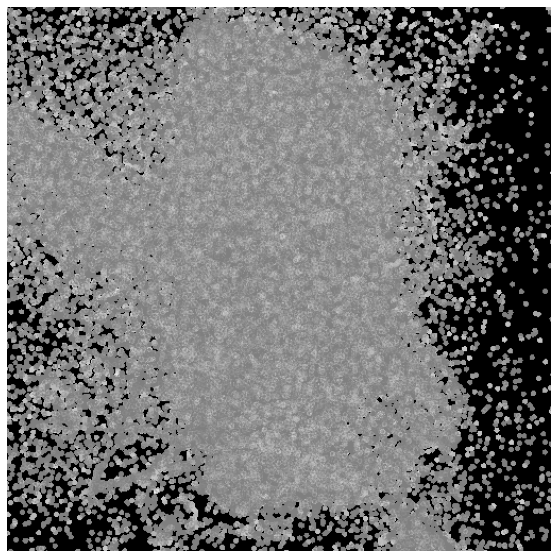

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.grid("off")
plt.axis("off");

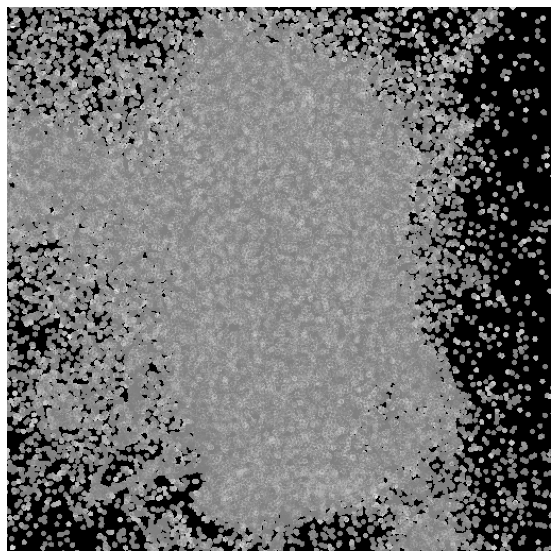

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(images[1, ..., :3].detach().cpu().numpy())
plt.grid("off")
plt.axis("off");

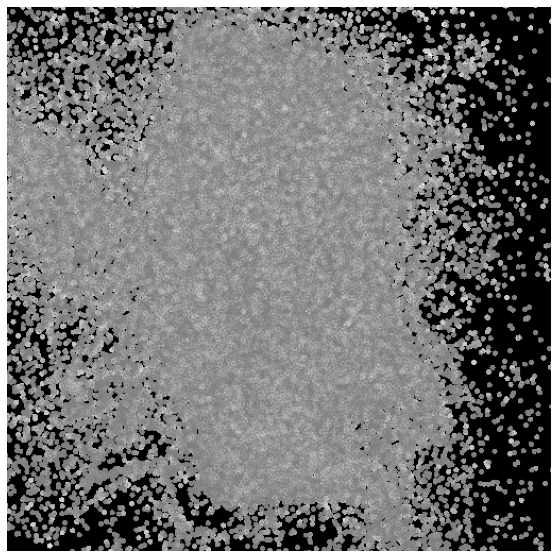

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(images[2, ..., :3].detach().cpu().numpy())
plt.grid("off")
plt.axis("off");

In [14]:
import os

opt =  config
trimap =  torch.load(os.path.join(opt.data_dir, 
            'trimap_{}.pth'.format(opt.raster_patch_size)))        
trimap['vert_tri_indices'].shape, trimap['vert_tri_weights'].shape, trimap['faces'].shape

(torch.Size([262144, 6]),
 torch.Size([1, 262144, 6, 1]),
 torch.Size([522242, 3]))

In [22]:
opt =  config
trimap =  torch.load(os.path.join(opt.data_dir, 
            'trimap_{}.pth'.format(1000)))        
trimap['vert_tri_indices'].shape, trimap['vert_tri_weights'].shape, trimap['faces'].shape

(torch.Size([1000000, 6]),
 torch.Size([1, 1000000, 6, 1]),
 torch.Size([1996002, 3]))

In [19]:
trimap['faces'][0].shape

torch.Size([1996002, 3])

In [20]:
from collections import OrderedDict

obj = OrderedDict(OrderedDict([
  ('vert_tri_indices', trimap['vert_tri_indices']),
  ('vert_tri_weights', trimap['vert_tri_weights']),
  ('faces', trimap['faces'][0]),
]))
file = './data/vert_tri_{}.pth'.format(1000)
torch.save(obj, file)